# 2D Parabola as a composition of ReLUs

ReLU makes it possible for us to model non-linear function with linear/affine functions. Without ReLU units all matrix transformations collapse into a single matrix. 

This notebook explores a simple exercise to use a two layer neural network to model a 2D parabola. We visualize the original parabola together with each composing 'ReLU line' to demonstrate how ReLU effectively models non-linearity.

*Bonus*: instead of using PyTorch backward propagation we derived our own gradients and used a vanilla gradient descent to update the model weights. Much credential goes to Jeremy's awesome [matrix calculus cheatsheet](https://arxiv.org/pdf/1802.01528.pdf). 


## Simulate Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# define high level parameters
# number of datapoints
m = 100
# number of ReLUs to use
k = 5
# seed for notebook repro
seed = 42
np.random.seed(seed)

In [3]:
# y = - (x-5)^2 + 5
X = np.linspace(-5, 15, m)
Y = - X**2 + 10 * X - 20
noise = np.random.normal(0, 2, size=m) 
Y += noise
X.shape, Y.shape

((100,), (100,))

In [4]:
# shuffle
shuffle_idx = np.random.permutation(len(X))
X = X[shuffle_idx]
Y = Y[shuffle_idx]
X.shape, Y.shape

((100,), (100,))

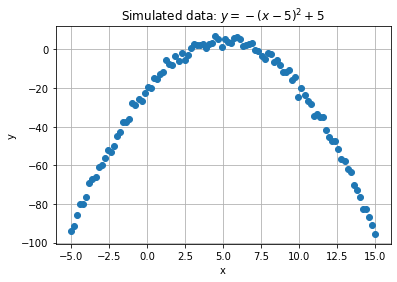

In [5]:
plt.plot(X, Y, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Simulated data: $y = - (x-5)^2 + 5$')
plt.grid(True)
plt.show()

## Define Model and Loss

In [6]:
# Model: ReLU(X x W1 + b1) x W2 + b2 = Y
# X: mx1, W1: 1xk, b1: 1xk
# W2: kx1, b2: 1x1, Y: mx1
W1 = np.random.uniform(-1, 1, size=(1, k))
b1 = np.random.uniform(-1, 1, size=(1, k))
W2 = np.random.uniform(-1, 1, size=(k, 1))
b2 = np.random.uniform(-1, 1, size=(1, 1))
W1.shape, b1.shape, W2.shape, b2.shape

((1, 5), (1, 5), (5, 1), (1, 1))

In [7]:
def relu(x):
    mask = x < 0
    x = x.copy()
    x[mask] = 0
    return x
test_x = np.random.uniform(-1, 1, size=(5))
test_x, relu(test_x)

(array([ 0.48834105,  0.44187985, -0.38387842,  0.08508046,  0.01762815]),
 array([0.48834105, 0.44187985, 0.        , 0.08508046, 0.01762815]))

In [8]:
def mse(y1, y2):
    y1, y2 = np.squeeze(y1), np.squeeze(y2)
    s = y1.shape[0]
    return np.sum((y1-y2) ** 2) / s
y1 = np.array([1, 2, 3])
y2 = np.array([4, 5, 6])
mse(y1, y2)

9.0

## Forward Pass

In [9]:
# m x k
U = X[:, None] @ W1 + b1
# m x k
V = relu(U)
# m x 1
Y_pred = V @ W2 + b2
U.shape, V.shape, Y_pred.shape

((100, 5), (100, 5), (100, 1))

## Backward Propagation

In [10]:
# m x 1
dLdY = 2 / m * (Y_pred - Y[:, None])
# 1 x 1
dLdb2 = np.ones((1, m)) @ dLdY
# k x 1
dLdW2 = V.transpose() @ dLdY
# m x k
dLdV = dLdY @ W2.transpose()
dLdY.shape, dLdb2.shape, dLdW2.shape, dLdV.shape

((100, 1), (1, 1), (5, 1), (100, 5))

In [11]:
# m x k
dVdU = (U > 0).astype(int)
# m x k
dLdU = dLdV * dVdU
dLdU.shape

(100, 5)

In [12]:
# 1 x k
dLdb1 = np.ones((1, m)) @ dLdU
# 1 x k
dLdW1 = X[:, None].transpose() @ dLdU
dLdb1.shape, dLdW1.shape

((1, 5), (1, 5))

In [13]:
# update model weights
def update(W, dW, eta):
    # modify in place
    return W - eta * dW

In [14]:
# everything together
def train_one_batch(x, y, W1, b1, W2, b2, eta):
    # batch size
    b = x.shape[0]

    # b x k
    U = x[:, None] @ W1 + b1
    # b x k
    V = relu(U)
    # b x 1
    y_pred = V @ W2 + b2

    # b x 1
    dLdY = 2 / b * (y_pred - y[:, None])
    # 1 x 1
    dLdb2 = np.ones((1, b)) @ dLdY
    # k x 1
    dLdW2 = V.transpose() @ dLdY
    # b x k
    dLdV = dLdY @ W2.transpose()
    # b x k
    dVdU = (U > 0).astype(int)
    # b x k
    dLdU = dLdV * dVdU
    # 1 x k
    dLdb1 = np.ones((1, b)) @ dLdU
    # 1 x k
    dLdW1 = x[:, None].transpose() @ dLdU
    # import pdb; pdb.set_trace()

    W1_update = update(W1, dLdW1, eta)
    b1_update = update(b1, dLdb1, eta)
    W2_update = update(W2, dLdW2, eta)
    b2_update = update(b2, dLdb2, eta)

    return W1_update, b1_update, W2_update, b2_update, y_pred

## Train

In [15]:
def batchify(m, b):
    # return list of idxes the size of b,
    # until m runs out
    idx = 0
    while idx < m:
        r = list(range(idx, min(idx+b, m)))
        yield r
        idx += b
for r in batchify(10, 3):
    print(r)

[0, 1, 2]
[3, 4, 5]
[6, 7, 8]
[9]


In [16]:
# epochs
e = 5000
# batch size
b = 10
# learning rate
eta = 0.001

# initial weights
W1 = np.random.uniform(-1, 1, size=(1, k))
b1 = np.random.uniform(-1, 1, size=(1, k))
W2 = np.random.uniform(-1, 1, size=(k, 1))
b2 = np.random.uniform(-1, 1, size=(1, 1))

# training loop
for ep in range(e):
    for idx in batchify(m, b):
        # get batch input
        x, y = X[idx], Y[idx]
        # import pdb; pdb.set_trace()
        # train one batch
        W1, b1, W2, b2, y_pred = train_one_batch(x, y, W1, b1, W2, b2, eta)
        # import pdb; pdb.set_trace()
    
    if ep % 200 == 0:
        # get loss
        l = mse(y, y_pred)
        print(f"loss: {round(l, 3)}")
        

loss: 811.901
loss: 77.424
loss: 34.55
loss: 21.793
loss: 24.337
loss: 23.721
loss: 21.344
loss: 18.703
loss: 16.39
loss: 14.519
loss: 13.045
loss: 11.889
loss: 10.945
loss: 10.152
loss: 9.459
loss: 8.934
loss: 8.508
loss: 8.116
loss: 7.811
loss: 7.555
loss: 7.34
loss: 7.154
loss: 6.988
loss: 6.84
loss: 6.764


## Visualize

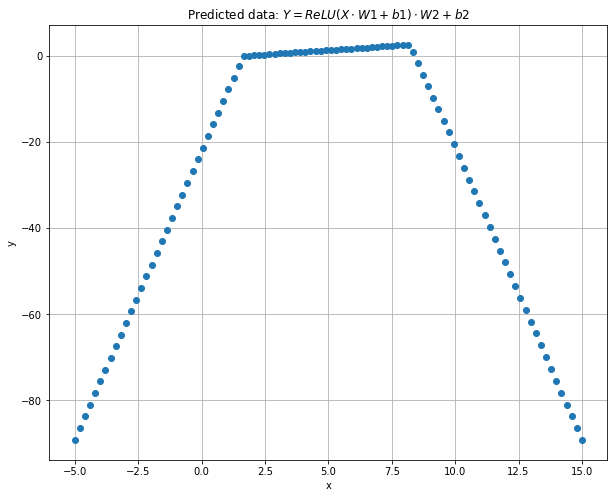

In [17]:
# visualize predictions
U = X[:, None] @ W1 + b1
# b x k
V = relu(U)
# b x 1
y_pred = V @ W2 + b2

fig = plt.figure(figsize=(10, 8))

plt.plot(X, y_pred, 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Predicted data: $Y = ReLU(X \cdot W1 + b1) \cdot W2 + b2$')
plt.grid(True)
plt.show()

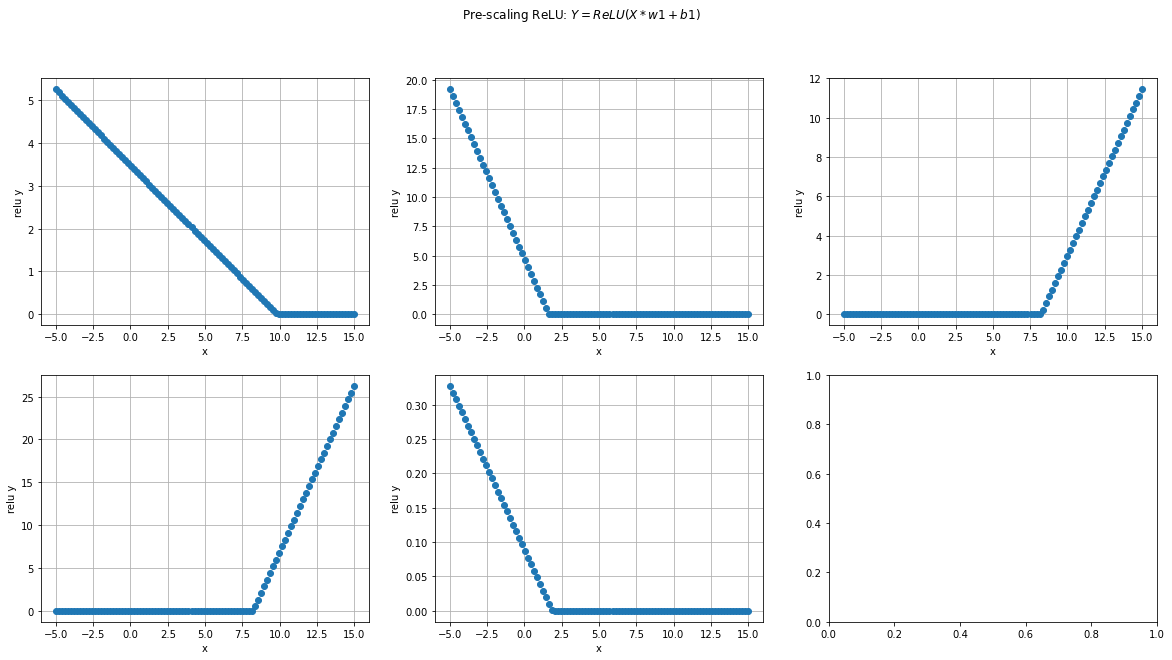

In [18]:
# Pre-scaling: ReLU(X * w1 + b1) 
y_relus = []
for i in range(k):
    y_relus.append(relu(X * W1[0, i] + b1[0, i]))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for r in range(2):
    for c in range(3):
        i = r * 3 + c
        if i >= len(y_relus):
            continue
        
        ax = axes[r, c]
        ax.plot(X, y_relus[i], 'o')
        ax.set_xlabel('x')
        ax.set_ylabel('relu y')
        ax.grid(True)

plt.suptitle('Pre-scaling ReLU: $Y = ReLU(X * w1 + b1)$')
plt.show()

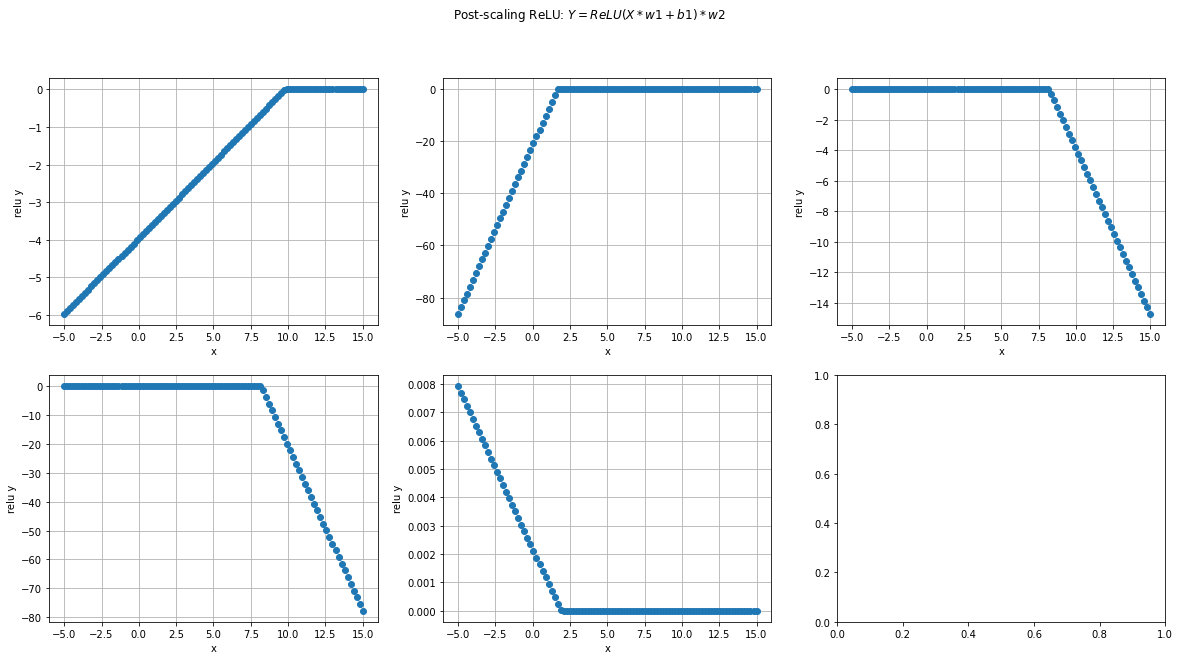

In [19]:
# Post-scaling: ReLU(X * w1 + b1) * w2
y_relus = []
for i in range(k):
    y_relus.append(relu(X * W1[0, i] + b1[0, i]) * W2[i, 0])

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for r in range(2):
    for c in range(3):
        i = r * 3 + c
        if i >= len(y_relus):
            continue
        
        ax = axes[r, c]
        ax.plot(X, y_relus[i], 'o')
        ax.set_xlabel('x')
        ax.set_ylabel('relu y')
        ax.grid(True)

plt.suptitle('Post-scaling ReLU: $Y = ReLU(X * w1 + b1) * w2$')
plt.show()

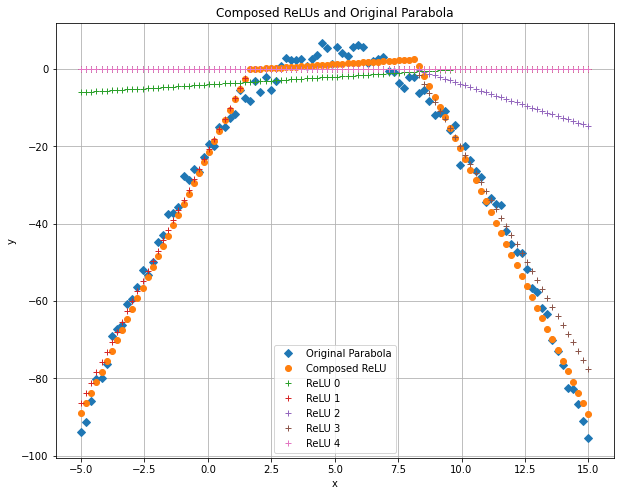

In [20]:
fig = plt.figure(figsize=(10, 8))

plt.plot(X, Y, 'D', label='Original Parabola')
plt.plot(X, y_pred, 'o', label="Composed ReLU")
for i in range(k):
    plt.plot(X, y_relus[i], '+', label=f"ReLU {i}")

plt.xlabel('x')
plt.ylabel('y')
plt.title('Composed ReLUs and Original Parabola')
plt.grid(True)
plt.legend()
plt.show()